<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/Week_3_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import copy

Energy = -19


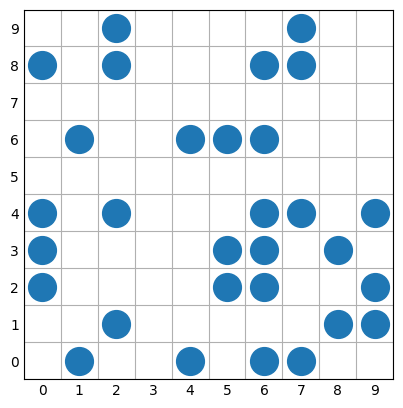

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Grid class
class grid():
    def __init__(self, length, N):
        # Initialize grid dimensions and RNG
        self.length = length
        self.grid_spaces = self.length**2
        self.N = N
        self.rng = np.random.default_rng()

        # Track occupied positions
        self.occupied_positions = set()
        self.particles = []

        # Generate random positions for N particles without overlap
        while len(self.particles) < N:
            x = self.rng.integers(0, length)
            y = self.rng.integers(0, length)
            if (x, y) not in self.occupied_positions:
                self.particles.append(particle(x, y))
                self.occupied_positions.add((x, y))

    def move_particle(self, index):
        # Determine empty spaces
        empty_spaces = [
            (i, j)
            for i in range(self.length)
            for j in range(self.length)
            if (i, j) not in self.occupied_positions
        ]

        # Choose a random empty space
        rand_empty_space = empty_spaces[self.rng.integers(0, len(empty_spaces))]

        # Update particle's position and occupied positions
        old_position = (self.particles[index].x, self.particles[index].y)
        self.occupied_positions.remove(old_position)
        self.particles[index].x, self.particles[index].y = rand_empty_space
        self.occupied_positions.add(rand_empty_space)

  # Visualize grid for debugging
    def plot_grid(self):
      fig = plt.figure()
      ax = fig.add_subplot(1, 1, 1)

      # Define gridlines that align correctly
      gridlines = np.arange(0, self.length + 1)  # Include 0 to max_value + 1

      # Set major ticks at integer values
      ax.set_xticks(gridlines)
      ax.set_yticks(gridlines)

      # Set minor ticks in between
      minor_ticks = gridlines - 0.5
      ax.set_xticks(minor_ticks, minor=True)
      ax.set_yticks(minor_ticks, minor=True)

      # Add grid lines for minor ticks
      ax.grid(which='minor')

      # Turn off tick labels
      ax.tick_params(axis='both', which='both', length=0)

      # Plot the point
      x_vals = [p.x for p in self.particles]
      y_vals = [p.y for p in self.particles]
      ax.scatter(x_vals, y_vals, 400)

      # Set bounds and aspect ratio
      ax.set_xlim(-0.5, self.length - 0.5)
      ax.set_ylim(-0.5, self.length - 0.5)
      ax.set_aspect('equal', adjustable='box')

    def calculate_energy(self):
      self.energy = 0
      self.checked_spaces = set()

      for i in range(self.N):
        x = self.particles[i].x
        y = self.particles[i].y
        # Define neighboring spaces
        neighbors = [[x, y + 1],
                     [x, y - 1],
                     [x - 1, y],
                     [x + 1, y]]

        # Account for periodic boundary conditions
        for direction in neighbors:
          for j,axis_value in enumerate(direction):
            if axis_value == -1:
              direction[j] += self.length
            elif axis_value == self.length:
              direction[j] -= self.length
            else:
              continue

          if (tuple(direction) in self.occupied_positions) and (tuple(direction) not in self.checked_spaces):
            self.energy -= 1
          else:
            continue

        self.checked_spaces.add((x,y))

      return self.energy



# Particle class
class particle():
    def __init__(self, x, y):
        self.x = x
        self.y = y

class dynamics():
    def __init__(self,length,N,nsteps,temperature):
      self.system = grid(length,N)
      self.nsteps = nsteps
      self.T = temperature

    def perform_dynamics(self):
      self.energy = []
      self.energy.append(self.system.calculate_energy())

      # Account for probability of choosing an empty space to move to
      self.detailed_balance_factor = (self.system.grid_spaces - self.system.N) / self.system.grid_spaces

      # Perform moves
      for i in range(self.nsteps):
        new_system = copy.deepcopy(self.system)
        new_system.move_particle(new_system.rng.integers(0,new_system.N))
        new_energy = new_system.calculate_energy()

        if new_energy <= self.energy[i]:

          rand = new_system.rng.random()

          # The following weights the accepted moves by the probability
          # of choosing an empty space. It seems to me that this would
          # be necessary, but I'm not sure.
          if rand <= self.detailed_balance_factor:
            self.energy.append(new_energy)
            self.system = copy.deepcopy(new_system)

          elif rand > self.detailed_balance_factor:
            self.energy.append(self.energy[i])

        elif new_energy > self.energy[i]:
          delta_E = new_energy - self.energy[i]
          acceptance_prob = self.detailed_balance_factor * np.exp(-delta_E/self.T)
          rand = new_system.rng.random()

          if rand <= acceptance_prob:
            self.energy.append(new_energy)
            self.system = copy.deepcopy(new_system)

          elif rand > acceptance_prob:
            self.energy.append(self.energy[i])

      return self.energy

    def plot_energy(self):
      fig = plt.Figure()
      ax = fig.add_subplot(1,1,1)
      x_vals = np.arange(self.nsteps+1)
      ax.plot(x_vals,self.energy)
      ax.set_xlabel('Number of Steps')
      ax.set_ylabel('Energy')
      return fig



grid_instance = grid(10, 30)
print(f'Energy = {grid_instance.calculate_energy()}')
grid_instance.plot_grid()


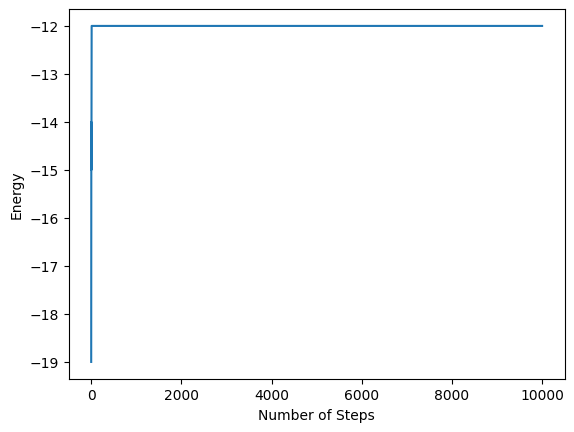

In [51]:
test_run = dynamics(10, 25, 10000, 100)
test_run.perform_dynamics()
test_run.plot_energy()

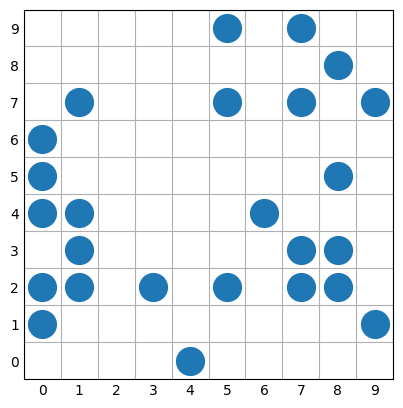

In [52]:
test_run.system.plot_grid()